# Before vs After RL Tuning

## Summary of what was added and how to use it

**RLlib inference fix (2025/2026):**
- Use `get_module()` + `forward_inference()` instead of deprecated `get_policy()`
- `num_env_runners=1` so learned params are applied
- Tuned `intervention_threshold` (e.g. 0.4, 0.5, 0.6) replaces default 0.55
- **Result:** `after_confs` differ from `before_confs` on some claims

**How to use:**
- **Notebook:** Run all cells (Load → Before → After → Observation Matrix → Plots)
- **CLI:** `python -m src.main --input data/train_claims.json --rl-tune --rl-iterations 5`
- **Repro:** `python scripts/test_rllib_inference.py`


In [1]:
import sys
from pathlib import Path

# Run from repo root (e.g. jupyter --notebook-dir=.) or from notebooks/
ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import json
from src.agents.claim_extractor import extract_claims
from src.agents.verifier import verify_claims
from src.agents.corrector import correct_results, DEFAULT_PARAMS

# Load from data/train_claims.json (align plot with your training data)
train_path = ROOT / "data" / "train_claims.json"
examples = json.loads(train_path.read_text())
if not isinstance(examples, list):
    examples = [examples]

# Use all claims for long Observation Matrix
N_PLOT = len(examples)
examples = examples[:N_PLOT]

# Short labels for x-axis (claim snippet)
def short_label(claim, max_len=28):
    s = (claim[:max_len] + "..") if len(claim) > max_len else claim
    return s.replace("\n", " ").strip()

labels = [short_label(ex["claim"]) for ex in examples]
print("Loaded", len(examples), "examples from", train_path.name)
print("Labels (first 3):", labels[:3])

Loaded 50 examples from train_claims.json
Labels (first 3): ['Breaking: 7.2 magnitude eart..', 'The moon landing was faked i..', 'The mayor said the budget wa..']


## 2. Before results (default params)

Run **verify → correct** with **no tuning**: the corrector uses hardcoded `DEFAULT_PARAMS` (e.g. `intervention_threshold=0.55`, `causal_bias=0.4`, `causal_truth=0.85`). We record the **final confidence** for each (sub-)claim.

In [2]:
before_params = None  # uses DEFAULT_PARAMS
before_confs = []
before_statuses = []
before_details = []

for ex, label in zip(examples, labels):
    claims = extract_claims(ex["claim"])
    v_res, graph = verify_claims(claims)
    corrected, _ = correct_results(v_res, graph, params=before_params)
    confs = [r["confidence"] for r in corrected]
    statuses = [r.get("status", "?") for r in corrected]
    mean_conf = sum(confs) / len(confs) if confs else 0.0
    before_confs.append(mean_conf)
    before_statuses.append(statuses[0] if statuses else "?")
    before_details.append({"label": label, "confs": confs, "mean": mean_conf})

print("Before params:", DEFAULT_PARAMS)
print("Before mean confidence per example:", before_confs)

Before params: {'intervention_threshold': 0.55, 'causal_bias': 0.4, 'causal_truth': 0.85}
Before mean confidence per example: [0.7, 0.85, 0.825, 0.6, 0.45, 0.65, 0.6, 0.45, 0.45, 0.45, 0.45, 0.675, 0.6000000000000001, 0.45, 0.7, 0.6, 0.8, 0.65, 0.55, 0.75, 0.45, 0.55, 0.75, 0.7, 0.45, 0.7, 0.7, 0.8, 0.45, 0.65, 0.8, 0.45, 0.65, 0.75, 0.75, 0.45, 0.6, 0.7, 0.7, 0.65, 0.6, 0.8, 0.8, 0.8, 0.65, 0.45, 0.75, 0.45, 0.45, 0.65]


## 3. After (RL-tuned params)

Run **tune_correction** — PPO training with `get_module` + `forward_inference` to extract learned threshold. Requires: `pip install torch 'ray[rllib]>=2.9.0'`

In [3]:
dataset = []
for ex in examples:
    claims = extract_claims(ex["claim"])
    v_res, graph = verify_claims(claims)
    dataset.append((v_res, graph, ex["ground_truth"]))

# Train/test: use data/test_claims.json (unseen) if available, else 80/20 split
test_path = ROOT / "data" / "test_claims.json"
if test_path.exists():
    test_raw = json.loads(test_path.read_text())
    if not isinstance(test_raw, list):
        test_raw = [test_raw]
    test_dataset = []
    for ex in test_raw:
        claims = extract_claims(ex.get("claim", ""))
        v_res, graph = verify_claims(claims)
        test_dataset.append((v_res, graph, ex.get("ground_truth", {})))
    train_dataset = dataset
    print(f"Test on new claims: {test_path.name} ({len(test_dataset)} unseen examples)")
else:
    split = max(1, int(len(dataset) * 0.8))
    train_dataset = dataset[:split]
    test_dataset = dataset[split:]
    print(f"Train/test: 80/20 split (holdout {len(test_dataset)} examples)")

# Short training loop: 5-10 iters for testing. Learned params applied via get_module + forward_inference.
RL_ITERATIONS = 8
try:
    import torch  # noqa: F401
    from src.rl_tuner import tune_correction
    after_params = tune_correction(train_dataset, num_iterations=RL_ITERATIONS, test_dataset=test_dataset)
    # Keep only param keys for correct_results; metrics live in after_params for the next section
    print("After (tuned) params:", {k: v for k, v in after_params.items() if k in ("intervention_threshold", "causal_bias", "causal_truth", "best_threshold")})
except ImportError as e:
    print("RL tuner skipped — install PyTorch and ray[rllib]: pip install torch 'ray[rllib]>=2.9.0'")
    print("  Error:", e)
    after_params = dict(DEFAULT_PARAMS)
    print("Using fallback (default) params — no training ran.")
    if test_dataset:
        from src.rl_tuner import evaluate_metrics
        after_params["metrics_pre"] = evaluate_metrics(test_dataset, None)
        after_params["metrics_post"] = after_params["metrics_pre"]
except Exception as e:
    print("RL tuner failed:", e)
    after_params = dict(DEFAULT_PARAMS)
    print("Using fallback (default) params — no training ran.")
    if test_dataset:
        from src.rl_tuner import evaluate_metrics
        after_params["metrics_pre"] = evaluate_metrics(test_dataset, None)
        after_params["metrics_post"] = after_params["metrics_pre"]

after_confs = []
after_statuses = []
for ex, label in zip(examples, labels):
    claims = extract_claims(ex["claim"])
    v_res, graph = verify_claims(claims)
    corrected, _ = correct_results(v_res, graph, params=after_params)
    confs = [r["confidence"] for r in corrected]
    statuses = [r.get("status", "?") for r in corrected]
    mean_conf = sum(confs) / len(confs) if confs else 0.0
    after_confs.append(mean_conf)
    after_statuses.append(statuses[0] if statuses else "?")

print("After mean confidence per example:", after_confs)

# Before/After report: compare untuned vs tuned on same claims (conf drop, status flip)
print("\n--- Before/After Report (same claims) ---")
training_ran = after_params.get("reward_history") is not None and len(after_params.get("reward_history", [])) > 0
if not training_ran:
    print("  (Training skipped — before and after identical, using default params)")
for i, label in enumerate(labels):
    bc, ac = before_confs[i], after_confs[i]
    bs, as_ = before_statuses[i], after_statuses[i]
    changed = " ← changed" if (bc != ac or bs != as_) else ""
    print(f"  {label}: conf {bc:.2f} → {ac:.2f}  |  status {bs} → {as_}{changed}")

Test on new claims: test_claims.json (10 unseen examples)


2026-02-13 12:08:47,407	INFO worker.py:2007 -- Started a local Ray instance.


/Users/weilee/Downloads/FakeNewsVerifier/.venv/lib/python3.13/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2026-02-13 12:08:49,162	WARNING algorithm_config.py:5118 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


/Users/weilee/Downloads/FakeNewsVerifier/.venv/lib/python3.13/site-packages/ray/rllib/algorithms/algorithm.py:527: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/weilee/Downloads/FakeNewsVerifier/.venv/lib/python3.13/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/weilee/Downloads/FakeNewsVerifier/.venv/lib/python3.13/site-packages/ray/tune/logger/unified.py:5

(SingleAgentEnvRunner pid=98470) DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
2026-02-13 12:08:51,443	WARNING rl_module.py:459 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


2026-02-13 12:08:51,887	WARNING util.py:61 -- Install gputil for GPU system monitoring.


  Iteration 1/8: Mean reward = 33.000
  Iteration 2/8: Mean reward = 32.283
  Iteration 3/8: Mean reward = 32.125


/Users/weilee/Downloads/FakeNewsVerifier/.venv/lib/python3.13/site-packages/ray/rllib/utils/metrics/stats/ema.py:124: RuntimeWarning: Mean of empty slice
  return np.nanmean(self._values_to_merge)


  Iteration 4/8: Mean reward = 33.108
  Iteration 5/8: Mean reward = 32.488
  Iteration 6/8: Mean reward = 33.200


  Iteration 7/8: Mean reward = 32.587
  Iteration 8/8: Mean reward = 32.908



  RL is Getting Better at Fake News Detection!

  Mean reward over iterations:  33.000 → 32.908  (↓ downward)

  Accuracy (holdout):  Pre-tune 50.0%  →  Post-tune 50.0%  (Δ +0.0%)
  Brier score (lower better):  Pre 0.234  →  Post 0.229
  ECE (lower better):          Pre 0.480  →  Post 0.490
  Avg interventions/episode:   Pre 0.30  →  Post 0.00
  Post-tune: interventions on real claims 0.00, on fake claims 0.00

  Threshold for success: mean reward > 0.7 and test accuracy +15% vs baseline.
    (accuracy Δ 0.0% not ≥ 15%)
    → Iterate env (e.g. richer states, graph embeddings) or try more iterations/seeds.

After (tuned) params: {'best_threshold': 0.4, 'intervention_threshold': 0.4, 'causal_bias': 0.4, 'causal_truth': 0.85}
After mean confidence per example: [0.7, 0.85, 0.825, 0.6, 0.475, 0.65, 0.6, 0.4, 0.45, 0.4, 0.4, 0.675, 0.6000000000000001, 0.45, 0.7, 0.6, 0.8, 0.65, 0.55, 0.75, 0.5, 0.55, 0.75, 0.7, 0.5, 0.7, 0.7, 0.8, 0.45, 0.65, 0.8, 0.45, 0.65, 0.75, 0.75, 0.45, 0.6, 0.7, 0.7

## Observation Matrix for Before/After Training

Long table comparing each claim: **before** (default params) vs **after** (RL-tuned params). Columns: claim, before_conf, after_conf, expected_conf, status_before, status_after, is_fake, pred_before, pred_after, correct_before, correct_after.

In [4]:
import pandas as pd

# Build observation matrix: one row per claim (long table)
CONF_THRESHOLD = 0.5  # conf < this => predicted fake
rows = []
for i in range(len(examples)):
    ex = examples[i]
    gt = ex.get("ground_truth", {})
    is_fake = gt.get("is_fake", True)
    expected = gt.get("expected_conf", 0.5)
    bc, ac = before_confs[i], after_confs[i]
    bs, as_ = before_statuses[i], after_statuses[i]
    pred_before = bc < CONF_THRESHOLD
    pred_after = ac < CONF_THRESHOLD
    correct_before = pred_before == is_fake
    correct_after = pred_after == is_fake
    rows.append({
        "claim": ex["claim"],
        "before_conf": round(bc, 3),
        "after_conf": round(ac, 3),
        "expected_conf": expected,
        "status_before": bs,
        "status_after": as_,
        "is_fake": is_fake,
        "pred_before": "fake" if pred_before else "real",
        "pred_after": "fake" if pred_after else "real",
        "correct_before": correct_before,
        "correct_after": correct_after,
    })

df = pd.DataFrame(rows)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 60)
pd.set_option("display.width", None)
display(df)
print(f"\nAccuracy: before {df['correct_before'].mean()*100:.1f}%, after {df['correct_after'].mean()*100:.1f}%")

,claim,before_conf,after_conf,expected_conf,status_before,status_after,is_fake,pred_before,pred_after,correct_before,correct_after
0,Breaking: 7.2 magnitude earthquake hits Nashville today!,0.700,0.700,0.75,Medium,Medium,False,real,real,True,True
1,The moon landing was faked in Nashville.,0.850,0.850,0.20,High,High,True,real,real,False,False
2,The mayor said the budget was approved. It has been repo...,0.825,0.825,0.70,High,High,False,real,real,True,True
3,Vaccines contain microchips to track people.,0.600,0.600,0.15,Medium,Medium,True,real,real,False,False
4,The council is in session today. The vote was unanimous.,0.450,0.475,0.80,Low (corrected),Low,False,fake,fake,False,False
5,Aliens built the pyramids. NASA has hidden the truth.,0.650,0.650,0.10,Medium,Medium,True,real,real,False,False
6,Federal Reserve announced a rate cut. Markets rallied.,0.600,0.600,0.85,Medium,Medium,False,real,real,True,True
7,5G towers cause COVID-19. It has been reported worldwide.,0.450,0.400,0.10,Low (corrected),Low,True,fake,fake,True,True
8,Local school board said enrollment is up. The superinten...,0.450,0.450,0.75,Low (corrected),Low,False,fake,fake,False,False
9,Earth is flat. Scientists have been lying for centuries.,0.450,0.400,0.05,Low (corrected),Low,True,fake,fake,True,True



Accuracy: before 48.0%, after 52.0%


### New plots from Observation Matrix

1. **Scatter**: before_conf vs after_conf (color = is_fake; diagonal = no change)
2. **Confidence by index**: line plot for before/after/expected

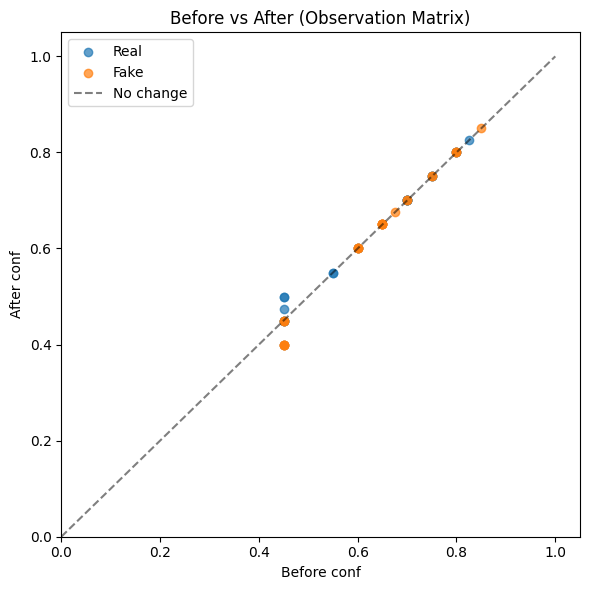

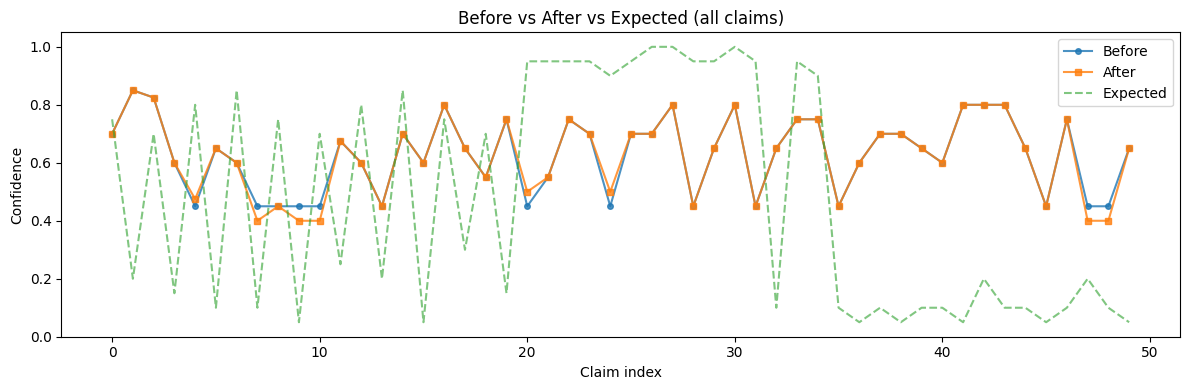

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot 1: Scatter — before_conf vs after_conf (color by is_fake)
fig1, ax1 = plt.subplots(figsize=(6, 6))
fake_mask = df["is_fake"]
ax1.scatter(df.loc[~fake_mask, "before_conf"], df.loc[~fake_mask, "after_conf"], c="C0", label="Real", alpha=0.7)
ax1.scatter(df.loc[fake_mask, "before_conf"], df.loc[fake_mask, "after_conf"], c="C1", label="Fake", alpha=0.7)
ax1.plot([0, 1], [0, 1], "k--", alpha=0.5, label="No change")
ax1.set_xlabel("Before conf")
ax1.set_ylabel("After conf")
ax1.set_title("Before vs After (Observation Matrix)")
ax1.legend()
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Plot 2: Line plot — confidence by claim index
fig2, ax2 = plt.subplots(figsize=(12, 4))
x = np.arange(len(df))
ax2.plot(x, df["before_conf"], "o-", label="Before", color="C0", alpha=0.8, markersize=4)
ax2.plot(x, df["after_conf"], "s-", label="After", color="C1", alpha=0.8, markersize=4)
ax2.plot(x, df["expected_conf"], "--", label="Expected", color="C2", alpha=0.6)
ax2.set_xlabel("Claim index")
ax2.set_ylabel("Confidence")
ax2.set_title("Before vs After vs Expected (all claims)")
ax2.legend()
ax2.set_ylim(0, 1.05)
plt.tight_layout()
out_dir = ROOT / "notebooks" / "output"
out_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_dir / "observation_matrix_plot.png", dpi=120)
plt.show()

## 4. Reward convergence

Policy learning over iterations (↑ = RL getting better).

  RL is Getting Better at Fake News Detection!

  Mean reward over iterations:  33.000 → 32.908  (↓ downward)
  Test on New Claims (holdout):  Pre-tune 50.0%  →  Post-tune 50.0%  (Δ +0.0%)

  Threshold for Success: mean reward > 0.7 and test accuracy +15% vs baseline.
    (accuracy Δ 0.0% not ≥ 15%)
  → If not met, iterate env (e.g. richer states with graph embeddings).


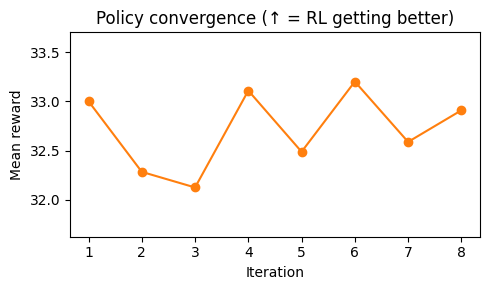

In [6]:
# Threshold for Success + Logs/Analysis (reward convergence)
reward_history = after_params.get("reward_history") or []
metrics_pre = after_params.get("metrics_pre") or {}
metrics_post = after_params.get("metrics_post") or {}

print("=" * 60)
print("  RL is Getting Better at Fake News Detection!")
print("=" * 60)

if reward_history:
    start_r, end_r = reward_history[0], reward_history[-1]
    trend = "↑ upward" if end_r >= start_r else "↓ downward"
    print(f"\n  Mean reward over iterations:  {start_r:.3f} → {end_r:.3f}  ({trend})")
else:
    print("\n  Mean reward over iterations:  (no history — RL training did not run. Install: pip install torch 'ray[rllib]>=2.9.0')")

if metrics_pre and metrics_post:
    acc_pre = metrics_pre.get("accuracy", 0) * 100
    acc_post = metrics_post.get("accuracy", 0) * 100
    delta = acc_post - acc_pre
    print(f"  Test on New Claims (holdout):  Pre-tune {acc_pre:.1f}%  →  Post-tune {acc_post:.1f}%  (Δ {delta:+.1f}%)")
    if 10 <= delta <= 20:
        print("  → RL is working (accuracy +10–20%).")
    elif delta > 20:
        print("  → RL is working (accuracy +>20%).")
    mean_reward = sum(reward_history) / len(reward_history) if reward_history else 0
    success = mean_reward > 0.7 and delta >= 15.0
    print("\n  Threshold for Success: mean reward > 0.7 and test accuracy +15% vs baseline.")
    if success:
        print("  ✓ Success: both conditions met.")
    else:
        if reward_history and mean_reward <= 0.7:
            print(f"    (mean reward {mean_reward:.2f} not > 0.7)")
        if delta < 15.0:
            print(f"    (accuracy Δ {delta:.1f}% not ≥ 15%)")
        print("  → If not met, iterate env (e.g. richer states with graph embeddings).")
else:
    print("\n  (Pre/post metrics require test_dataset; use data/test_claims.json or 80/20 split.)")

# Logs/Analysis: reward convergence plot (policy learning)
if reward_history:
    try:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(range(1, len(reward_history) + 1), reward_history, "o-", color="C1")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Mean reward")
        ax.set_title("Policy convergence (↑ = RL getting better)")
        # Use data range: rewards can be 0-1 (per-claim) or 30+ (batch sum)
        lo, hi = min(reward_history), max(reward_history)
        margin = max(0.5, (hi - lo) * 0.2) if hi > lo else 1.0
        ax.set_ylim(lo - margin, hi + margin)
        plt.tight_layout()
        out_dir = ROOT / "notebooks" / "output"
        out_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_dir / "reward_convergence.png", dpi=120)
        plt.show()
    except Exception:
        pass
print()

## 5. Bar chart: Before vs After

Per-claim confidence comparison.

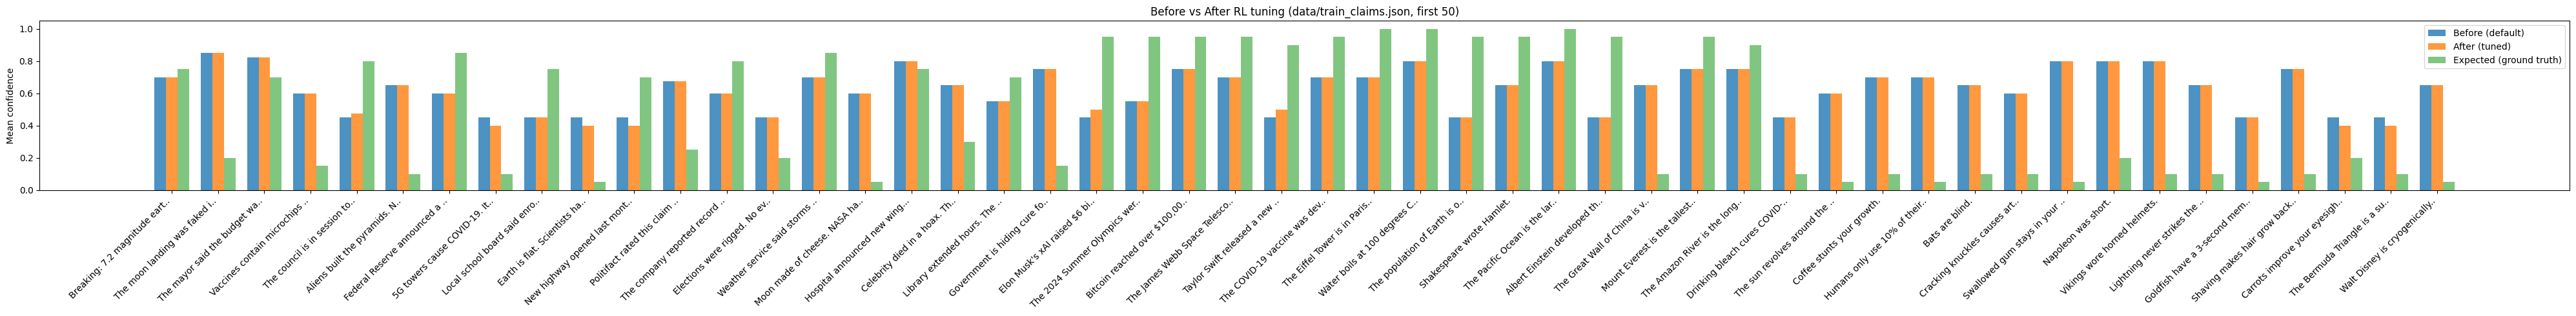

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# expected must match examples order (same as before_confs / after_confs)
expected = [ex["ground_truth"]["expected_conf"] for ex in examples]
n = len(labels)
assert n == len(before_confs) == len(after_confs) == len(expected), "Lengths must match"

x = np.arange(n)
w = 0.25

fig, ax = plt.subplots(figsize=(max(8, n * 0.8), 5))
ax.bar(x - w, before_confs, width=w, label="Before (default)", color="C0", alpha=0.8)
ax.bar(x, after_confs, width=w, label="After (tuned)", color="C1", alpha=0.8)
ax.bar(x + w, expected, width=w, label="Expected (ground truth)", color="C2", alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Mean confidence")
ax.set_title("Before vs After RL tuning (data/train_claims.json, first %d)" % n)
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
out_dir = ROOT / "notebooks" / "output"
out_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_dir / "before_after_confidence.png", dpi=120)
plt.show()